In [1]:
#import required libraries

from pyspark.sql import SparkSession
from datetime import datetime
import pyspark.pandas as ps
import os
import shutil
from glob import glob
import numpy as np
from pyspark.sql.functions import when
from pyspark.ml.feature import StringIndexer
from pyspark.ml.feature import OneHotEncoder
from pyspark.ml.feature import VectorAssembler
from pyspark.ml import Pipeline

# ML models
from pyspark.ml.regression import LinearRegression
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml.regression import GBTRegressor

#visualisation
import matplotlib.pyplot as plt
%matplotlib inline

C:\Users\Anks\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\pyspark\pandas\__init__.py:50: UserWarning: 'PYARROW_IGNORE_TIMEZONE' environment variable was not set. It is required to set this environment variable to '1' in both driver and executor sides if you use pyarrow>=2.0.0. pandas-on-Spark will set it for you but it does not work if there is a Spark context already launched.
  warnings.warn(


# Starts spark session

In [2]:
session = SparkSession.builder.appName('Cars').getOrCreate()

# Data Preprocessing

In [3]:
def merge_data(): #function to merge all csv in dataset into single dataframe
    car_files = glob(pathname='A:/pyspark-main/dataset/*.csv')
    cars = ps.DataFrame() #initialize empty dataframe
    for file in car_files:
        brand = file.split("/")[-1].split(".")[0] #get model name from file name
        if not (brand == "unclean cclass" or brand == "unclean focus" or brand =='focus'or brand =='cclass'): #exclude "unclean" datasets
            cdf = ps.read_csv(file)
            cdf["brand"] = brand ## add model name as new column into dataframe
            if brand == "hyundi":
                cdf.rename(columns={'tax(£)': 'tax'}, inplace=True)  #change column name for hyundi dataset
                cars = cars.append(cdf)
                del(cdf)              
            else:
                cars = cars.append(cdf)
                del(cdf)  
                
    cars=cars.to_spark() #convert back to spark dataframe
    return cars 

In [4]:
sparkdf= merge_data() #merge datasets into single dataframe
sparkdf = sparkdf.filter(sparkdf.year != 2060) #remove year 2060

C:\Users\Anks\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\pyspark\pandas\utils.py:975: PandasAPIOnSparkAdviceWarning: If `index_col` is not specified for `read_csv`, the default index is attached which can cause additional overhead.
  warnings.warn(message, PandasAPIOnSparkAdviceWarning)
C:\Users\Anks\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\pyspark\pandas\frame.py:8865: FutureWarning: The DataFrame.append method is deprecated and will be removed in a future version. Use pyspark.pandas.concat instead.
  warnings.warn(
C:\Users\Anks\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\pyspark\pandas\utils.py:975: PandasAPIOnSparkAdviceWarning: If `index_col` is not specified for `to_spark`, the existing index is lost when converting to Spark DataFrame.
  wa

In [5]:
sparkdf.toPandas().head() #inspect data

,model,year,price,transmission,mileage,fuelType,tax,mpg,engineSize,brand,tax(£),fuel type,engine size,mileage2,fuel type2,engine size2,reference
0,A1,2017,12500,Manual,15735,Petrol,150.0,55.4,1.4,dataset\audi,NaN,None,None,None,None,None,None
1,A6,2016,16500,Automatic,36203,Diesel,20.0,64.2,2.0,dataset\audi,NaN,None,None,None,None,None,None
2,A1,2016,11000,Manual,29946,Petrol,30.0,55.4,1.4,dataset\audi,NaN,None,None,None,None,None,None
3,A4,2017,16800,Automatic,25952,Diesel,145.0,67.3,2.0,dataset\audi,NaN,None,None,None,None,None,None
4,A3,2019,17300,Manual,1998,Petrol,145.0,49.6,1.0,dataset\audi,NaN,None,None,None,None,None,None


In [6]:
sparkdf.toPandas().info() # look at type of data and missing values

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 117902 entries, 0 to 117901
Data columns (total 17 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   model         117902 non-null  object 
 1   year          117902 non-null  int32  
 2   price         117902 non-null  object 
 3   transmission  117902 non-null  object 
 4   mileage       116988 non-null  object 
 5   fuelType      108539 non-null  object 
 6   tax           94326 non-null   float64
 7   mpg           99186 non-null   float64
 8   engineSize    108539 non-null  float64
 9   brand         117902 non-null  object 
 10  tax(£)        4860 non-null    float64
 11  fuel type     9363 non-null    object 
 12  engine size   9363 non-null    object 
 13  mileage2      9363 non-null    object 
 14  fuel type2    8449 non-null    object 
 15  engine size2  8449 non-null    object 
 16  reference     9363 non-null    object 
dtypes: float64(4), int32(1), object(12)
memory usage

In [7]:
sparkdf.toPandas().describe()

,year,tax,mpg,engineSize,tax(£)
count,117902.000000,94326.000000,99186.000000,108539.000000,4860.000000
mean,2017.106088,120.255285,55.166950,1.661646,121.147119
std,2.132205,63.404540,16.138556,0.557060,58.003289
min,1970.000000,0.000000,0.300000,0.000000,0.000000
25%,2016.000000,125.000000,47.100000,1.200000,125.000000
50%,2017.000000,145.000000,54.300000,1.600000,145.000000
75%,2019.000000,145.000000,62.800000,2.000000,145.000000
max,2020.000000,580.000000,470.800000,6.600000,555.000000


In [8]:
sparkdf.printSchema() #check schema

root
 |-- model: string (nullable = true)
 |-- year: integer (nullable = true)
 |-- price: string (nullable = true)
 |-- transmission: string (nullable = true)
 |-- mileage: string (nullable = true)
 |-- fuelType: string (nullable = true)
 |-- tax: integer (nullable = true)
 |-- mpg: double (nullable = true)
 |-- engineSize: double (nullable = true)
 |-- brand: string (nullable = true)
 |-- tax(£): integer (nullable = true)
 |-- fuel type: string (nullable = true)
 |-- engine size: string (nullable = true)
 |-- mileage2: string (nullable = true)
 |-- fuel type2: string (nullable = true)
 |-- engine size2: string (nullable = true)
 |-- reference: string (nullable = true)



In [9]:
sparkdf.select('year').distinct().show(60,truncate=False)

sparkdf = sparkdf.filter(sparkdf.year != 2060) #remove entry with year 2060


+----+
|year|
+----+
|2003|
|2007|
|2018|
|2015|
|2006|
|2013|
|1997|
|2014|
|2019|
|2004|
|1998|
|2020|
|2012|
|2009|
|2016|
|2005|
|2010|
|2011|
|2008|
|2017|
|2002|
|1996|
|2001|
|2000|
|1999|
|1991|
|1995|
|1970|
+----+



In [10]:
## Check categorical columns
categorical_columns = ['model','transmission',
                      'fuelType','brand']

for i in categorical_columns:  #check unqiue values in categorical columns
    print(f"{i} has {sparkdf.select(i).distinct().count()} unique values")
    #sparkdf.select(i).distinct().show()
    

model has 195 unique values
transmission has 4 unique values
fuelType has 6 unique values
brand has 13 unique values


# Data Transformation for model

In [11]:
def cat_pipe_stages(categorical_columns):  #function to create pipeline to convert all cat columns 
    pipeline_stages = []
    for categorial_column in categorical_columns:
        string_indexer = StringIndexer(inputCol = categorial_column, 
                                       outputCol = categorial_column + 'Index')
        encoder = OneHotEncoder(inputCols = [string_indexer.getOutputCol()], 
                                outputCols=[categorial_column + "classVec"])
        pipeline_stages += [string_indexer, encoder]
    return pipeline_stages

In [12]:
cat_pipe_stages = cat_pipe_stages(categorical_columns)

In [13]:
print(cat_pipe_stages)

[StringIndexer_7324da03286c, OneHotEncoder_f8eb5fec099c, StringIndexer_aabd7f290221, OneHotEncoder_749165448410, StringIndexer_f4dec8d1e602, OneHotEncoder_8ef57d92a0f4, StringIndexer_38add4a85f9c, OneHotEncoder_92e69c5845ed]


In [14]:
# execute pipeline to convert categorical columns to index and vec in dataframe 
def convertcat(df,stages):
    pipeline = Pipeline(stages = stages)
    pipeline_model = pipeline.fit(df)
    df = pipeline_model \
    .transform(df) \
    .select(['*'])
    return df

In [15]:
newdf = convertcat(sparkdf,cat_pipe_stages)

In [16]:
newdf.show()

+-----+----+-----+------------+-------+--------+---+----+----------+-----+----------+----------------+-----------------+--------------------+-------------+----------------+----------+-------------+
|model|year|price|transmission|mileage|fuelType|tax| mpg|engineSize|brand|modelIndex|   modelclassVec|transmissionIndex|transmissionclassVec|fuelTypeIndex|fuelTypeclassVec|brandIndex|brandclassVec|
+-----+----+-----+------------+-------+--------+---+----+----------+-----+----------+----------------+-----------------+--------------------+-------------+----------------+----------+-------------+
|   A1|2017|12500|      Manual|  15735|  Petrol|150|55.4|       1.4| audi|      21.0|(194,[21],[1.0])|              0.0|       (3,[0],[1.0])|          0.0|   (4,[0],[1.0])|       5.0|(8,[5],[1.0])|
|   A6|2016|16500|   Automatic|  36203|  Diesel| 20|64.2|       2.0| audi|      39.0|(194,[39],[1.0])|              2.0|       (3,[2],[1.0])|          1.0|   (4,[1],[1.0])|       5.0|(8,[5],[1.0])|
|   A1|201

In [17]:
#selecting only the columns we want from above

#note tax and mpg were dropped because of some null values.. if wish to include, have to drop those rows
vec_df = newdf.select('price','year','tax','mileage','mpg',
                      'engineSize','modelclassVec','transmissionclassVec','fuelTypeclassVec','brandclassVec')

In [18]:
vec_df.show()

+-----+----+---+-------+----+----------+----------------+--------------------+----------------+-------------+
|price|year|tax|mileage| mpg|engineSize|   modelclassVec|transmissionclassVec|fuelTypeclassVec|brandclassVec|
+-----+----+---+-------+----+----------+----------------+--------------------+----------------+-------------+
|12500|2017|150|  15735|55.4|       1.4|(194,[21],[1.0])|       (3,[0],[1.0])|   (4,[0],[1.0])|(8,[5],[1.0])|
|16500|2016| 20|  36203|64.2|       2.0|(194,[39],[1.0])|       (3,[2],[1.0])|   (4,[1],[1.0])|(8,[5],[1.0])|
|11000|2016| 30|  29946|55.4|       1.4|(194,[21],[1.0])|       (3,[0],[1.0])|   (4,[0],[1.0])|(8,[5],[1.0])|
|16800|2017|145|  25952|67.3|       2.0|(194,[20],[1.0])|       (3,[2],[1.0])|   (4,[1],[1.0])|(8,[5],[1.0])|
|17300|2019|145|   1998|49.6|       1.0|(194,[15],[1.0])|       (3,[0],[1.0])|   (4,[0],[1.0])|(8,[5],[1.0])|
|13900|2016| 30|  32260|58.9|       1.4|(194,[21],[1.0])|       (3,[2],[1.0])|   (4,[0],[1.0])|(8,[5],[1.0])|
|13250|201

In [19]:
## Convert features that we want into a vector column named as features
vector_assembler_inputs = ['year','tax','mileage','mpg','engineSize',
                           'modelclassVec','transmissionclassVec','fuelTypeclassVec','brandclassVec']
vector_assembler = VectorAssembler(inputCols = vector_assembler_inputs, 
                                   outputCol = "features")

In [20]:
## execute vector assembler pipeline

def vecpipe(df,stages):
    pipeline = Pipeline(stages = stages)
    pipeline_model = pipeline.fit(df)
    label_column = 'price'
    sdf = pipeline_model \
    .transform(vec_df) \
    .select(['features', label_column])
    
    return sdf

In [21]:
spark_features_df = vecpipe(newdf,[vector_assembler])

In [22]:
spark_features_df.toPandas().head(10)  #data ready for training

,features,price
0,"(2017.0, 150.0, 15735.0, 55.4, 1.4, 0.0, 0.0, ...",12500
1,"(2016.0, 20.0, 36203.0, 64.2, 2.0, 0.0, 0.0, 0...",16500
2,"(2016.0, 30.0, 29946.0, 55.4, 1.4, 0.0, 0.0, 0...",11000
3,"(2017.0, 145.0, 25952.0, 67.3, 2.0, 0.0, 0.0, ...",16800
4,"(2019.0, 145.0, 1998.0, 49.6, 1.0, 0.0, 0.0, 0...",17300
5,"(2016.0, 30.0, 32260.0, 58.9, 1.4, 0.0, 0.0, 0...",13900
6,"(2016.0, 30.0, 76788.0, 61.4, 2.0, 0.0, 0.0, 0...",13250
7,"(2016.0, 20.0, 75185.0, 70.6, 2.0, 0.0, 0.0, 0...",11750
8,"(2015.0, 20.0, 46112.0, 60.1, 1.4, 0.0, 0.0, 0...",10200
9,"(2016.0, 30.0, 22451.0, 55.4, 1.4, 0.0, 0.0, 0...",12000


In [23]:
spark_features_df.toPandas().features

0        (2017.0, 150.0, 15735.0, 55.4, 1.4, 0.0, 0.0, ...
1        (2016.0, 20.0, 36203.0, 64.2, 2.0, 0.0, 0.0, 0...
2        (2016.0, 30.0, 29946.0, 55.4, 1.4, 0.0, 0.0, 0...
3        (2017.0, 145.0, 25952.0, 67.3, 2.0, 0.0, 0.0, ...
4        (2019.0, 145.0, 1998.0, 49.6, 1.0, 0.0, 0.0, 0...
                               ...                        
99181    (2020.0, 145.0, 500.0, 55.4, 2.0, 0.0, 0.0, 0....
99182    (2020.0, 145.0, 2500.0, 55.4, 2.0, 0.0, 0.0, 0...
99183    (2019.0, 145.0, 11612.0, 41.5, 2.1, 0.0, 0.0, ...
99184    (2019.0, 145.0, 2426.0, 45.6, 2.0, 0.0, 0.0, 0...
99185    (2019.0, 145.0, 2075.0, 52.3, 2.9, 0.0, 0.0, 0...
Name: features, Length: 99186, dtype: object

In [24]:
# Split the Raw Features and Labelled DataFrame into a Training DataFrame and a Test DataFrame
train_df, test_df = spark_features_df.randomSplit([0.7, 0.3], seed=4020)
train_df.count(), test_df.count()

(69560, 29626)

# Data Visualisation

In [25]:
import seaborn as sns
reg_num_pandas = vec_df.toPandas()

In [26]:
reg_num_pandas.corr()

,price,year,tax,mileage,mpg,engineSize
price,1.000000,0.492059,0.307667,-0.417946,-0.296440,0.638113
year,0.492059,1.000000,0.195825,-0.740443,-0.132909,-0.038560
tax,0.307667,0.195825,1.000000,-0.220786,-0.451446,0.278420
mileage,-0.417946,-0.740443,-0.220786,1.000000,0.185671,0.109081
mpg,-0.296440,-0.132909,-0.451446,0.185671,1.000000,-0.248214
engineSize,0.638113,-0.038560,0.278420,0.109081,-0.248214,1.000000


<AxesSubplot:>

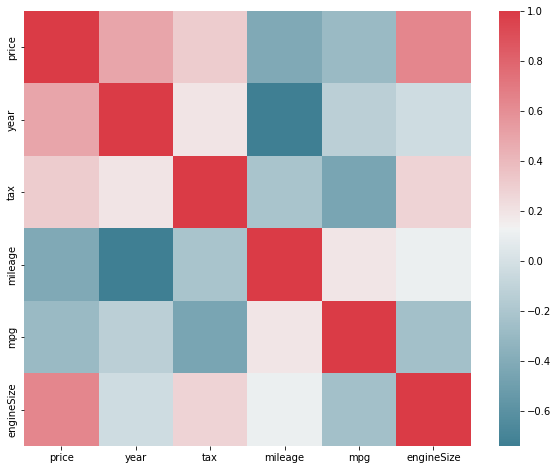

In [27]:
plt.figure(figsize=(10,8)) 

cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(reg_num_pandas.corr(), cmap=cmap)

We checked the correlation matrix and the corresponding heatmap to avoid multicollinearity between the features. It seems we do not need to drop any column.

# Multi-variate Linear Regression Model

In [28]:
# Train a Multi-variate Linear Regression Model on the Training DataFrame
multi_reg = LinearRegression(featuresCol = 'features', labelCol = 'price',
                                       regParam=0.3, elasticNetParam=0.3)
multi_reg_model = multi_reg.fit(train_df)

In [29]:
# Output Multi-variate Linear Regression Model Summary Statistics to evaluate the Training Model
print("Model Coefficients: " + str(multi_reg_model.coefficients))
print("Intercept: " + str(multi_reg_model.intercept))
training_summary = multi_reg_model.summary
print("RMSE: %f" % training_summary.rootMeanSquaredError)
print("R-SQUARED: %f" % training_summary.r2)
print("TRAINING DATASET DESCRIPTIVE SUMMARY: ")
train_df.describe().show()
print("TRAINING DATASET RESIDUALS: ")
training_summary.residuals.show()

Model Coefficients: [1398.0044551827089,-11.477428584733264,-0.09079506430546294,-79.55431162539217,5972.704685756576,-1646.7762113903975,-110.88198091843432,44.85923136935791,1501.3257262381842,-4207.8111662354195,-2581.7792379304183,-1418.5737116870873,375.3044338413358,74.39624189617507,88.80179030622949,-2643.9738454415547,-3581.6429610803116,-2182.419152821415,-2904.5500773850854,3152.333874912145,-329.31907173432694,2840.72917386049,-3016.487923935019,-1421.5018118957275,2534.6256066535398,166.7711833664046,-2211.511296938878,-1552.284999118509,-1666.393431107947,-1092.2599936695688,-5659.503849866654,2087.802613106315,-290.0460449600767,126.95705296776175,7918.917455660546,379.8537395589649,-4837.816831014724,1745.4554227220362,7256.833615522727,-833.7717890737995,1031.117255971975,-689.9045598476115,656.3163006768045,1098.61030384295,2352.582227393715,2328.6820231405495,-2507.310946906357,-2171.206263750794,-691.2830316691577,-1664.3466892312417,2106.211545659797,6101.570460001

/opt/conda/lib/python3.7/site-packages/pyspark/sql/context.py:127: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  FutureWarning


+-------+------------------+
|summary|             price|
+-------+------------------+
|  count|             69560|
|   mean|16840.863369752733|
| stddev| 9893.265474368769|
|    min|               450|
|    max|            159999|
+-------+------------------+

TRAINING DATASET RESIDUALS: 
+-------------------+
|          residuals|
+-------------------+
|  5883.983194134198|
|  9223.631225297693|
|  5482.119467490818|
|   6401.24592867773|
| 2392.3647950687446|
|  5769.622640212532|
| 3779.9466806869023|
| 2123.7293031536974|
| 2725.8943194835447|
| 3875.1614052015357|
| 1827.5702448589727|
| 1007.5312009104528|
| 2592.2747299107723|
| -1263.927047799807|
| -2938.037775473669|
| 102.96973243961111|
| -750.1967236301862|
|-380.88745968742296|
| 1652.0563008338213|
| 485.23000428825617|
+-------------------+
only showing top 20 rows



In [30]:
# Apply the Trained Linear Regression Model to the Test DataFrame to make predictions
test_multi_reg_predictions_df = multi_reg_model.transform(test_df)
print("TEST DATASET PREDICTIONS AGAINST ACTUAL TARGET VALUES: ")
test_multi_reg_predictions_df.select("features", "price","prediction").show(50)

TEST DATASET PREDICTIONS AGAINST ACTUAL TARGET VALUES: 
+--------------------+-----+------------------+
|            features|price|        prediction|
+--------------------+-----+------------------+
|(214,[0,1,2,3,4,2...| 8488| 1290.926892538555|
|(214,[0,1,2,3,4,2...| 5000|3183.2812621840276|
|(214,[0,1,2,3,4,2...| 5995| 3650.403441452887|
|(214,[0,1,2,3,4,2...| 4990|1836.2529213703237|
|(214,[0,1,2,3,4,2...| 7150|  8856.06156556448|
|(214,[0,1,2,3,4,2...| 7999|5625.7162324581295|
|(214,[0,1,2,3,4,2...|12695| 10384.75054855831|
|(214,[0,1,2,3,4,2...|11500| 8291.651931124274|
|(214,[0,1,2,3,4,2...|10000|   7297.7183621726|
|(214,[0,1,2,3,4,2...|10995| 11452.70973194018|
|(214,[0,1,2,3,4,2...|12990|10482.655264900997|
|(214,[0,1,2,3,4,2...|10485|11581.542120710481|
|(214,[0,1,2,3,4,2...|11690|11200.293645692058|
|(214,[0,1,2,3,4,2...|11498| 10753.04483166663|
|(214,[0,1,2,3,4,2...|10998| 9324.104436884169|
|(214,[0,1,2,3,4,2...|11650| 15169.52011982724|
|(214,[0,1,2,3,4,2...|16485|1605

# Random Forest Regression Model

In [31]:
# Train a Random Forest Regression Model on the Training DataFrame
random_forest = RandomForestRegressor(featuresCol = 'features', 
                                       labelCol = 'price',seed=4020)
random_forest_model = random_forest.fit(train_df)

In [32]:
#numTrees=20, numFeatures=222
#print(str(random_forest_model.toDebugString))

In [33]:
# Apply the Trained Random Forest Regression Model to the Test DataFrame to make predictions
test_random_forest_predictions_df = random_forest_model.transform(test_df)
train_random_forest_predictions_df = random_forest_model.transform(train_df)

#output df that includes test data and predicted results
test_random_forest_predictions_df.show(10)

+--------------------+-----+------------------+
|            features|price|        prediction|
+--------------------+-----+------------------+
|(214,[0,1,2,3,4,2...| 8488|11464.227765989468|
|(214,[0,1,2,3,4,2...| 5000| 8341.320903527689|
|(214,[0,1,2,3,4,2...| 5995|11470.627467848282|
|(214,[0,1,2,3,4,2...| 4990| 7951.352170284859|
|(214,[0,1,2,3,4,2...| 7150| 9281.316616129212|
|(214,[0,1,2,3,4,2...| 7999| 8643.405407982624|
|(214,[0,1,2,3,4,2...|12695|  9081.16819858318|
|(214,[0,1,2,3,4,2...|11500| 8643.405407982624|
|(214,[0,1,2,3,4,2...|10000| 8643.405407982624|
|(214,[0,1,2,3,4,2...|10995| 9146.623787654364|
+--------------------+-----+------------------+
only showing top 10 rows



# Gradient-boosted tree regression

In [34]:
gbt = GBTRegressor(featuresCol="features",labelCol = 'price', maxIter=10,seed=4020)
gradient_boosted_tree_model = gbt.fit(train_df)

In [35]:
#numTrees=20, numFeatures=222
#print(str(gradient_boosted_tree_model.toDebugString))

In [36]:
gradient_boosted_tree_predictions_df =gradient_boosted_tree_model.transform(test_df)
gradient_boosted_tree_predictions_df_train =gradient_boosted_tree_model.transform(train_df)
gradient_boosted_tree_predictions_df.show(10)

+--------------------+-----+------------------+
|            features|price|        prediction|
+--------------------+-----+------------------+
|(214,[0,1,2,3,4,2...| 8488| 5112.428883931471|
|(214,[0,1,2,3,4,2...| 5000| 4124.973936392858|
|(214,[0,1,2,3,4,2...| 5995| 5658.737561670812|
|(214,[0,1,2,3,4,2...| 4990| 4063.834270660895|
|(214,[0,1,2,3,4,2...| 7150| 4418.929202538484|
|(214,[0,1,2,3,4,2...| 7999| 7503.606453100512|
|(214,[0,1,2,3,4,2...|12695| 8281.238725827958|
|(214,[0,1,2,3,4,2...|11500|8084.8413859275015|
|(214,[0,1,2,3,4,2...|10000| 7790.886119781876|
|(214,[0,1,2,3,4,2...|10995|8084.8413859275015|
+--------------------+-----+------------------+
only showing top 10 rows



# Model Evaluation

In [37]:
from pyspark.ml.evaluation import RegressionEvaluator

evaluator = RegressionEvaluator()
evaluator.setPredictionCol("prediction")
evaluator.setLabelCol('price')

#Multi-variate Linear Regression
r2_multi_linear = evaluator.evaluate(test_multi_reg_predictions_df,{evaluator.metricName: "r2"})
rmse_multi_linear = evaluator.evaluate(test_multi_reg_predictions_df,{evaluator.metricName: "rmse"})

#random_forest
r2_random_forest = evaluator.evaluate(test_random_forest_predictions_df,{evaluator.metricName: "r2"})
rmse_random_forest = evaluator.evaluate(test_random_forest_predictions_df,{evaluator.metricName: "rmse"})

r2_random_forest_train = evaluator.evaluate(train_random_forest_predictions_df,{evaluator.metricName: "r2"})
rmse_random_forest_train = evaluator.evaluate(train_random_forest_predictions_df,{evaluator.metricName: "rmse"})

#gradient_boosted_tree
r2_gradient_boosted_tree = evaluator.evaluate(gradient_boosted_tree_predictions_df,{evaluator.metricName: "r2"})
rmse_gradient_boosted_tree = evaluator.evaluate(gradient_boosted_tree_predictions_df,{evaluator.metricName: "rmse"})

r2_gradient_boosted_tree_train = evaluator.evaluate(gradient_boosted_tree_predictions_df_train,{evaluator.metricName: "r2"})
rmse_gradient_boosted_tree_train = evaluator.evaluate(gradient_boosted_tree_predictions_df_train,{evaluator.metricName: "rmse"})


print(f"R2 for multi-variate linear regression is {r2_multi_linear}")
print(f"RMSE for multi-variate linear regression is {rmse_multi_linear}")

print(f"R2 for random forest model is {r2_random_forest}")
print(f"RMSE for random forest model is {rmse_random_forest}")

print(f"R2 for random forest model of the training set is {r2_random_forest_train}")
print(f"RMSE for random forest model of the training set is {rmse_random_forest_train}")

print(f"R2 for gradient_boosted_tree model is {r2_gradient_boosted_tree}")
print(f"RMSE for gradient_boosted_tree model is {rmse_gradient_boosted_tree}")

print(f"R2 for gradient_boosted_tree model of the training set is {r2_gradient_boosted_tree_train}")
print(f"RMSE for gradient_boosted_tree model of the training set is {rmse_gradient_boosted_tree_train}")

R2 for multi-variate linear regression is 0.8534882703183052
RMSE for multi-variate linear regression is 3752.575606912581
R2 for random forest model is 0.8020169952354621
RMSE for random forest model is 4362.216428305776
R2 for random forest model of the training set is 0.8063625632578371
RMSE for random forest model of the training set is 4353.42637229223
R2 for gradient_boosted_tree model is 0.8487755022996987
RMSE for gradient_boosted_tree model is 3812.4515104745938
R2 for gradient_boosted_tree model of the training set is 0.8624331768752524
RMSE for gradient_boosted_tree model of the training set is 3669.385963511811


# Stops Spark session

In [38]:
session.stop()